# CS3920 - Machine Learning Assignment 3
## Wine dataset

In [1]:
from sklearn.datasets import load_wine
wine = load_wine()
wine.data.shape

(178, 13)

### Cross validation and training set

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(wine.data, wine.target, random_state=2406)

In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
svm = SVC() #Default C=1 & gamma=1/n_features
svm.fit(X_train, Y_train)
scores = cross_val_score (svm, X_train, Y_train) # Default cv=5
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())) # 0.2f = 2dp

0.72 accuracy with a standard deviation of 0.07


In [4]:
import numpy as np
# Find error rate
pred = svm.predict(X_test)
error_rate = (np.mean(pred != Y_test))
print ("Error rate %0.2f" %(error_rate))
print ("Accuracy",1-error_rate)

Error rate 0.33
Accuracy 0.6666666666666667


From alrually running and obtaining the error rate of the test SVM with default parameters, we can see that the estimated accuracy was correct. This is because the accuracy of the SVM on the test set was 67% this is within the standard deviation of the predicted accuracy of 72%, as its close.

The error rate of 33%, however can be improved on by introducing data preprocessing
Also data leakage can be avoided by using pipelines

### Pipelines

In [5]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
pipe = make_pipeline(MinMaxScaler(),SVC())

param_grid = {'svc__C': [0.01, 0.1, 1, 10 , 100], 'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}            
grid = GridSearchCV(pipe, param_grid=param_grid)
grid.fit(X_train, Y_train)
print ("Best cross-validation accuracy:", grid.best_score_)
print ("Best test set score:", grid.score(X_test, Y_test))
print ("Best parameters", grid.best_estimator_)

Best cross-validation accuracy: 1.0
Best test set score: 0.9555555555555556
Best parameters Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=1, gamma=1))])


In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
best_score = 0
best_parameters= 0

# Loop thorugh Normalisation types
for norm in [MinMaxScaler(), StandardScaler(), RobustScaler(), Normalizer()]:
    pipe = make_pipeline(norm,SVC())
    # Loop through SVM parameters
    param_grid = {'svc__C': [0.01, 0.1, 1, 10 , 100], 'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}            
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
    grid.fit(X_train, Y_train)
    if best_score < int(grid.best_score_):
        # Save best parameters and type
        best_score = int(grid.best_score_)
        best_parameters = grid.best_estimator_
        
# Results with best parameters
print ("Best score =", best_score)
print ("best parameters =", best_parameters)

Best score = 1
best parameters = Pipeline(steps=[('minmaxscaler', MinMaxScaler()), ('svc', SVC(C=1, gamma=1))])


From looking at the results of the grid search, its infers that MinMaxScaler is the most suitable normalisation method because it has the highest score with the training set.

### Predicting with grid search

In [7]:
pipe = make_pipeline(MinMaxScaler(), SVC())
param_grid = {'svc__C': [0.01, 0.1, 1, 10 , 100], 'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, Y_train)

preds = grid.predict(X_test) # Uses grid.best to predict labels
grid_error = (np.mean(preds != Y_test))
print ("Error rate for MinMaxScaler %0.2f" %(grid_error))

Error rate for MinMaxScaler 0.04


In [8]:
pipe = make_pipeline(StandardScaler(), SVC())
param_grid = {'svc__C': [0.01, 0.1, 1, 10 , 100], 'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, Y_train)

preds = grid.predict(X_test) # Uses grid.best to predict labels
grid_error = (np.mean(preds != Y_test))
print ("Error rate for StandardScaler %0.2f" %(grid_error))

Error rate for StandardScaler 0.04


### Cross-confromal predictor

In [9]:
from sklearn.model_selection import KFold
kf = KFold(shuffle=True, random_state=2406) # Deafult 5 folds

# Split training set into K folds
best_score=0
best_X_rest=0
best_Y_rest=0
best_X_fold=0
best_Y_fold=0

#Find best fold
for rest_index, fold_index in kf.split(wine.data):
    X_rest, X_fold = wine.data[rest_index], wine.data[fold_index]
    Y_rest, Y_fold = wine.target[rest_index], wine.target[fold_index]
    # X_fold, Y_fold = current fold
    # X_rest, Y_fold = other folds

    grid.fit(X_rest, Y_rest)
    if grid.score(X_fold, Y_fold) > best_score:
        best_score = grid.score(X_fold, Y_fold)
        best_X_fold = X_fold
        best_Y_fold = Y_fold
        best_X_rest = X_rest
        best_Y_rest = Y_rest          

In [10]:
# Refit with best fold
# rest = training, fold = test
grid.fit(best_X_rest, best_Y_rest)
score_dec=grid.decision_function(best_X_fold)
score_dec

array([[ 2.25701252,  0.90672374, -0.24955956],
       [ 2.25984442,  0.77910579, -0.20369542],
       [ 2.26193829,  0.81626382, -0.23645247],
       [ 2.23993588,  0.93296468, -0.23284838],
       [ 2.22043861,  1.09642193, -0.23411515],
       [ 2.23141214,  1.1489927 , -0.2516089 ],
       [ 2.24293716,  0.86908686, -0.22371061],
       [ 2.22087091,  1.06199402, -0.22891957],
       [ 2.27149544,  0.81373384, -0.2525037 ],
       [ 2.22664505,  1.18781307, -0.25783312],
       [ 2.26704248,  0.83628153, -0.25129435],
       [ 2.24704489,  0.863411  , -0.22813993],
       [ 2.25736183,  0.84057597, -0.23729683],
       [ 2.26397274,  0.81584161, -0.23999637],
       [ 1.08456579,  2.26519573, -0.26962284],
       [ 1.12549227,  2.23329208, -0.24863957],
       [ 0.79915634,  2.26960426, -0.24359626],
       [ 1.01424589,  2.24781138, -0.2487799 ],
       [ 1.13963654,  2.24306245, -0.25780735],
       [-0.23363039,  2.26701793,  0.79089552],
       [ 0.8663196 ,  2.2657591 , -0.255

Run through black box from Lab 9 to plot graph and find false p value

In [11]:
import math
def dist(x1,x2):
    return np.linalg.norm(x1-x2)

n_train = best_X_rest.shape[0]
n_test = best_X_fold.shape[0]
dist_own = math.inf * np.ones(n_train) # Infinity array size of len samples
dist_other = math.inf * np.ones(n_train)

for i in range(n_train-1):
    for j in range(i+1,n_train):
        current_dist = dist(best_X_rest[i],best_X_rest[j])
        if best_Y_rest[i]==best_Y_rest[j]:
            if (current_dist < dist_own[i]):
                dist_own[i] = current_dist
            if (current_dist < dist_own[j]):
                dist_own[j] = current_dist
        else:
            if (current_dist < dist_other[i]):
                dist_other[i] = current_dist
            if (current_dist < dist_other[j]):
                dist_other[j] = current_dist

In [12]:
score = np.zeros(n_train+1) # Conformity scores
p = np.zeros((n_test,3)) # 2d array of zeros width of 3 length n_test

for j in range(n_test):
    for l in range(3): # postulated label
        aug_dist_own = np.append(dist_own,math.inf)
        aug_dist_other = np.append(dist_other,math.inf)
        for i in range(n_train):
            current_dist = dist(best_X_rest[i],best_X_fold[j])
            if best_Y_rest[i]==l:
                if (current_dist < aug_dist_own[i]):
                    aug_dist_own[i] = current_dist
                if (current_dist < aug_dist_own[n_train]):
                    aug_dist_own[n_train] = current_dist
            else:
                if (current_dist < aug_dist_other[i]):
                    aug_dist_other[i] = current_dist
                if (current_dist < aug_dist_other[n_train]):
                    aug_dist_other[n_train] = current_dist
            # the following for loop is the careful version
            # of score = aug dist other / aug distance own
            for i in range(n_train+1):
                if aug_dist_own[i] == 0:
                    score[i] = math.inf
                    if (aug_dist_other[i] == 0):
                        score[i] = 0
                else:
                    score[i] = aug_dist_other[i] / aug_dist_own[i]
            p[j,l] = np.mean(score<=score[n_train]) # the p-value of l

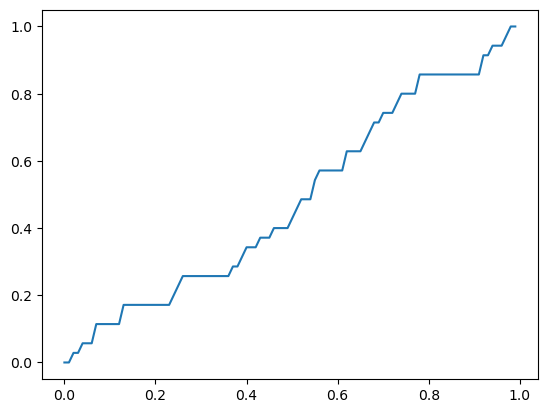

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
eps = np.zeros(100) # a range of significance levels
err = np.zeros(100) # the corresponding error rates
for k in range(100):
    eps[k] = k/100 # considering eps = k%
    err[k] = 0 # initializing the error rate
    for j in range(n_test):
        if (p[j,best_Y_fold[j]] <= eps[k]): # if we made an error
            err[k] = err[k] + 1 # count this error
    err[k] = err[k] / n_test # number of errors -> error rate
plt.plot(eps,err)

In [14]:
# False P value
def falsep (p,fold):
    a=np.array([0]*len(p),dtype=float)
    
    for i in range(len(p)):    
        snip = p[i]
        snip = np.delete(snip, fold[i]) #Take mean of P values minus true label
        a[i] = np.mean(snip)
    return np.mean(a)

In [15]:
falsep(p,best_Y_fold)

0.08482142857142858

## Neural networks

### Cross val

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(wine.data, wine.target, random_state=2406)

In [17]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier() #Default MLP classifier
mlp.fit(X_train, Y_train)
scores = cross_val_score (mlp, X_train, Y_train)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())) # 0.2f = 2dp

D:\Uni\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Uni\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Uni\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.78 accuracy with a standard deviation of 0.23


D:\Uni\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\Uni\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [18]:
# Error rate
pred = mlp.predict(X_test)
error_rate = (np.mean(pred != Y_test))
print ("Error rate %0.2f" %(error_rate))
print ("Accuracy", 1-error_rate)

Error rate 0.11
Accuracy 0.8888888888888888


### Pipelines

In [19]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=1000)
param_grid = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'hidden_layer_sizes': [2,10, 100, 1000, (10,10)],
             'solver' : ['sgd', 'adam']}            
grid = GridSearchCV(mlp, param_grid=param_grid, n_jobs = -1)

grid.fit(X_train, Y_train)
print ("Best cross-validation accuracy:", grid.best_score_)
print ("Best test set score:", grid.score(X_test, Y_test))
print ("Best parameters", grid.best_estimator_)

Best cross-validation accuracy: 0.97008547008547
Best test set score: 0.9333333333333333
Best parameters MLPClassifier(activation='tanh', hidden_layer_sizes=100, max_iter=1000)


In [20]:
from sklearn.pipeline import Pipeline
best_parameters= 0
best_score=float(0)
mlp = MLPClassifier(max_iter=1000)

# Loop thorugh Normalisation types
for norm in [MinMaxScaler(), StandardScaler(), RobustScaler(), Normalizer()]:
    pipe = Pipeline([("scaler", norm), ("mlp", mlp)])
    # Loop through mlp parameters
    param_grid = {'mlp__activation': ['identity', 'logistic', 'tanh', 'relu'] }            
    grid = GridSearchCV(pipe, param_grid=param_grid, n_jobs = -1)
    grid.fit(X_train, Y_train)
    if best_score < float(grid.best_score_):
        # Save best parameters and type
        best_score = float(grid.best_score_)
        best_parameters = grid.best_estimator_
        
# Results with best parameters
print ("Best score =", best_score)
print ("best parameters =", best_parameters)

Best score = 0.9925925925925926
best parameters = Pipeline(steps=[('scaler', MinMaxScaler()),
                ('mlp', MLPClassifier(activation='tanh', max_iter=1000))])


D:\Uni\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [21]:
pipe = Pipeline([("scaler", MinMaxScaler()), ("mlp", mlp)])
param_grid = {'mlp__activation': ['identity', 'logistic', 'tanh', 'relu'],
            'mlp__solver' : ['sgd', 'adam']}            
grid = GridSearchCV(pipe, param_grid=param_grid, n_jobs = -1)
grid.fit(X_train, Y_train)

preds = grid.predict(X_test) # Uses grid.best to predict labels
grid_error = (np.mean(preds != Y_test))
print ("Error rate for MinMaxScaler %0.2f" %(grid_error))

Error rate for MinMaxScaler 0.04


In [22]:
pipe = Pipeline([("scaler", StandardScaler()), ("mlp", mlp)])
param_grid = {'mlp__activation': ['identity', 'logistic', 'tanh', 'relu'],
            'mlp__solver' : ['sgd', 'adam']}            
grid = GridSearchCV(pipe, param_grid=param_grid, n_jobs = -1)
grid.fit(X_train, Y_train)

preds = grid.predict(X_test) # Uses grid.best to predict labels
grid_error = (np.mean(preds != Y_test))
print ("Error rate for StandardScaler %0.2f" %(grid_error))

Error rate for StandardScaler 0.07


D:\Uni\Anaconda\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


## USPS dataset

In [23]:
import gzip
with gzip.open('zip.train.gz','rb') as f:
    content = f.read()

In [24]:
# content

In [25]:
# Load files
Y_train = np.genfromtxt("zip.train.gz", delimiter=" ",  dtype='int', usecols=0) 
X_train = np.genfromtxt("zip.train.gz", delimiter=" ",  usecols=[*range(1,257)])

Y_test = np.genfromtxt("zip.test.gz", delimiter=" ",  dtype='int', usecols=0) 
X_test = np.genfromtxt("zip.test.gz", delimiter=" ",  usecols=[*range(1,257)]) 

# Merge into one dataset
data = np.array(X_train)
data = np.concatenate((data,X_test))
target = np.array(Y_train)
target = np.concatenate((target,Y_test))

### Cross validation

In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data, target, random_state=2406)

from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
svm = SVC() #Default C=1 & gamma=1/n_features
svm.fit(X_train, Y_train)
scores = cross_val_score (svm, X_train, Y_train) # Default cv=5
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())) # 0.2f = 2dp

0.97 accuracy with a standard deviation of 0.01


In [27]:
import numpy as np
# Find error rate
pred = svm.predict(X_test)
error_rate = (np.mean(pred != Y_test))
print ("Error rate %0.2f" %(error_rate))
print ("Accuracy",1-error_rate)

Error rate 0.03
Accuracy 0.9746236559139785


### Pipelines

In [28]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
pipe = make_pipeline(MinMaxScaler(),SVC())

param_grid = {'svc__C': [0.01, 0.1, 1, 10 , 100], 'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}            
grid = GridSearchCV(pipe, param_grid=param_grid, n_jobs=-1)
grid.fit(X_train, Y_train)
print ("Best cross-validation accuracy:", grid.best_score_)
print ("Best test set score:", grid.score(X_test, Y_test))
print ("Best parameters", grid.best_estimator_)

Best cross-validation accuracy: 0.968880969644611
Best test set score: 0.9746236559139785
Best parameters Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('svc', SVC(C=10, gamma=0.01))])


In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
best_score = 0
best_score=float(0)

# Loop thorugh Normalisation types
for norm in [MinMaxScaler(), StandardScaler(), RobustScaler(), Normalizer()]:
    pipe = make_pipeline(norm,SVC())
    # Loop through SVM parameters
    param_grid = {'svc__C': [0.01, 0.1, 1, 10 , 100], 'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}            
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
    grid.fit(X_train, Y_train)
    if best_score < float(grid.best_score_):
        # Save best parameters and type
        best_score = float(grid.best_score_)
        best_parameters = grid.best_estimator_
        
# Results with best parameters
print ("Best score =", best_score)
print ("best parameters =", best_parameters)

Best score = 0.9727529658598295
best parameters = Pipeline(steps=[('normalizer', Normalizer()), ('svc', SVC(C=10, gamma=1))])


### Predicting with grid search

In [33]:
pipe = make_pipeline(MinMaxScaler(), SVC())
param_grid = {'svc__C': [0.01, 0.1, 1, 10 , 100], 'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, Y_train)

preds = grid.predict(X_test) # Uses grid.best to predict labels
grid_error = (np.mean(preds != Y_test))
print ("Error rate for MinMaxScaler %0.2f" %(grid_error))

Error rate for MinMaxScaler 0.03


In [34]:
pipe = make_pipeline(StandardScaler(), SVC())
param_grid = {'svc__C': [0.01, 0.1, 1, 10 , 100], 'svc__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1)
grid.fit(X_train, Y_train)

preds = grid.predict(X_test) # Uses grid.best to predict labels
grid_error = (np.mean(preds != Y_test))
print ("Error rate for StandardScaler %0.2f" %(grid_error))

Error rate for StandardScaler 0.03


### Cross-conformal predictor

In [35]:
from sklearn.model_selection import KFold
kf = KFold(shuffle=True, random_state=2406) # Deafult 5 folds

# Split training set into K folds
best_score=0
best_X_rest=0
best_Y_rest=0
best_X_fold=0
best_Y_fold=0

#Find best fold
for rest_index, fold_index in kf.split(wine.data):
    X_rest, X_fold = data[rest_index], data[fold_index]
    Y_rest, Y_fold = target[rest_index], target[fold_index]
    # X_fold, Y_fold = current fold
    # X_rest, Y_fold = other folds

    grid.fit(X_rest, Y_rest)
    if grid.score(X_fold, Y_fold) > best_score:
        best_score = grid.score(X_fold, Y_fold)
        best_X_fold = X_fold
        best_Y_fold = Y_fold
        best_X_rest = X_rest
        best_Y_rest = Y_rest          

D:\Uni\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


In [36]:
# Refit with best fold
# rest = training, fold = test
grid.fit(best_X_rest, best_Y_rest)
score_dec=grid.decision_function(best_X_fold)
score_dec

array([[ 6.26050308, -0.29303305,  7.28677844,  8.25020569,  4.88850686,
         9.26849746,  1.74938527,  1.77827822,  3.77884326,  1.77328759],
       [ 9.30518008, -0.29549173,  6.03105117,  2.77095266,  8.25411665,
         3.80618697,  7.19253885,  0.80183959,  3.87559781,  2.7755087 ],
       [ 3.86191427,  9.26501996,  2.80669586, -0.28702735,  7.25993055,
         0.73936608,  5.06924556,  1.76350896,  6.24296643,  8.26588148],
       [ 2.76550109,  0.71949352,  5.19610388,  1.73259075,  7.23857731,
         0.73211435,  2.73404827,  9.30226525,  6.21835002,  8.2692805 ],
       [ 7.25983432, -0.282661  ,  8.26475411,  9.29634841,  2.80084152,
         4.82881215,  2.7620213 ,  0.73666721,  6.12461271,  2.79342912],
       [ 8.27370246,  2.75686737,  6.21290606,  1.74196745,  3.79059237,
         4.89282612,  9.30189096,  0.71902519,  7.26550796, -0.28717595],
       [ 4.97573421,  0.75385702,  8.23494168,  9.26789172,  6.09911674,
        -0.25236313,  3.84233581,  4.96003013

In [37]:
import math
def dist(x1,x2):
    return np.linalg.norm(x1-x2)

n_train = best_X_rest.shape[0]
n_test = best_X_fold.shape[0]
dist_own = math.inf * np.ones(n_train) # Infinity array size of len samples
dist_other = math.inf * np.ones(n_train)

for i in range(n_train-1):
    for j in range(i+1,n_train):
        current_dist = dist(best_X_rest[i],best_X_rest[j])
        if best_Y_rest[i]==best_Y_rest[j]:
            if (current_dist < dist_own[i]):
                dist_own[i] = current_dist
            if (current_dist < dist_own[j]):
                dist_own[j] = current_dist
        else:
            if (current_dist < dist_other[i]):
                dist_other[i] = current_dist
            if (current_dist < dist_other[j]):
                dist_other[j] = current_dist

In [41]:
X_train.shape

(6973, 256)

In [42]:
score = np.zeros(n_train+1) # Conformity scores
p = np.zeros((n_test,256)) # 2d array of zeros width of 3 length n_test

for j in range(n_test):
    for l in range(256): # postulated label
        aug_dist_own = np.append(dist_own,math.inf)
        aug_dist_other = np.append(dist_other,math.inf)
        for i in range(n_train):
            current_dist = dist(best_X_rest[i],best_X_fold[j])
            if best_Y_rest[i]==l:
                if (current_dist < aug_dist_own[i]):
                    aug_dist_own[i] = current_dist
                if (current_dist < aug_dist_own[n_train]):
                    aug_dist_own[n_train] = current_dist
            else:
                if (current_dist < aug_dist_other[i]):
                    aug_dist_other[i] = current_dist
                if (current_dist < aug_dist_other[n_train]):
                    aug_dist_other[n_train] = current_dist
            # the following for loop is the careful version
            # of score = aug dist other / aug distance own
            for i in range(n_train+1):
                if aug_dist_own[i] == 0:
                    score[i] = math.inf
                    if (aug_dist_other[i] == 0):
                        score[i] = 0
                else:
                    score[i] = aug_dist_other[i] / aug_dist_own[i]
            p[j,l] = np.mean(score<=score[n_train]) # the p-value of l

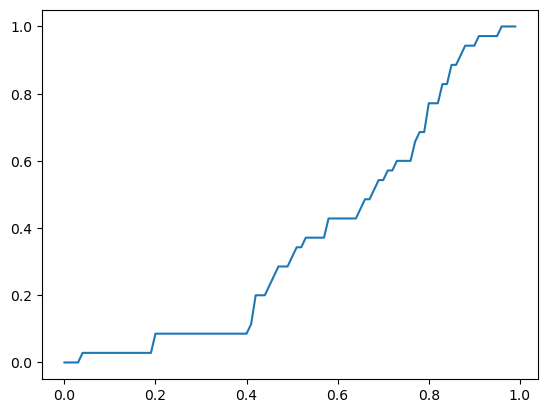

In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
eps = np.zeros(100) # a range of significance levels
err = np.zeros(100) # the corresponding error rates
for k in range(100):
    eps[k] = k/100 # considering eps = k%
    err[k] = 0 # initializing the error rate
    for j in range(n_test):
        if (p[j,best_Y_fold[j]] <= eps[k]): # if we made an error
            err[k] = err[k] + 1 # count this error
    err[k] = err[k] / n_test # number of errors -> error rate
plt.plot(eps,err)

In [44]:
# False P value
def falsep (p,fold):
    a=np.array([0]*len(p),dtype=float)
    
    for i in range(len(p)):    
        snip = p[i]
        snip = np.delete(snip, fold[i]) #Take mean of P values minus true label
        a[i] = np.mean(snip)
    return np.mean(a)

In [45]:
falsep(p,best_Y_fold)

0.0074875505757858694

## Neural Netowrks
### Cross val

In [46]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(data, target, random_state=2406)

In [47]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier() #Default MLP classifier
mlp.fit(X_train, Y_train)
scores = cross_val_score (mlp, X_train, Y_train)
print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())) # 0.2f = 2dp

0.96 accuracy with a standard deviation of 0.01


In [48]:
# Error rate
pred = mlp.predict(X_test)
error_rate = (np.mean(pred != Y_test))
print ("Error rate %0.2f" %(error_rate))
print ("Accuracy", 1-error_rate)

Error rate 0.04
Accuracy 0.9643010752688173


### Pipelines

In [50]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=1000)
param_grid = {'activation': ['identity', 'logistic', 'tanh', 'relu'], 'hidden_layer_sizes': [2,10, 100, 1000, (10,10)],
             'solver' : ['sgd', 'adam']}            
grid = GridSearchCV(mlp, param_grid=param_grid, n_jobs = -1)

grid.fit(X_train, Y_train)
print ("Best cross-validation accuracy:", grid.best_score_)
print ("Best test set score:", grid.score(X_test, Y_test))
print ("Best parameters", grid.best_estimator_)

KeyboardInterrupt: 

Iterrupt left at In[50] as USPS database was taking too long to run with grid search of MLP classifier

In [51]:
from sklearn.pipeline import Pipeline
best_parameters= 0
best_score=float(0)
mlp = MLPClassifier(max_iter=1000)

# Loop thorugh Normalisation types
for norm in [MinMaxScaler(), StandardScaler(), RobustScaler(), Normalizer()]:
    pipe = Pipeline([("scaler", norm), ("mlp", mlp)])
    # Loop through mlp parameters
    param_grid = {'mlp__activation': ['identity', 'logistic', 'tanh', 'relu'] }            
    grid = GridSearchCV(pipe, param_grid=param_grid, n_jobs = -1)
    grid.fit(X_train, Y_train)
    if best_score < float(grid.best_score_):
        # Save best parameters and type
        best_score = float(grid.best_score_)
        best_parameters = grid.best_estimator_
        
# Results with best parameters
print ("Best score =", best_score)
print ("best parameters =", best_parameters)

Best score = 0.9624272997948197
best parameters = Pipeline(steps=[('scaler', MinMaxScaler()),
                ('mlp', MLPClassifier(max_iter=1000))])


In [52]:
pipe = Pipeline([("scaler", MinMaxScaler()), ("mlp", mlp)])
param_grid = {'mlp__activation': ['identity', 'logistic', 'tanh', 'relu'],
            'mlp__solver' : ['sgd', 'adam']}            
grid = GridSearchCV(pipe, param_grid=param_grid, n_jobs = -1)
grid.fit(X_train, Y_train)

preds = grid.predict(X_test) # Uses grid.best to predict labels
grid_error = (np.mean(preds != Y_test))
print ("Error rate for MinMaxScaler %0.2f" %(grid_error))

Error rate for MinMaxScaler 0.03


In [53]:
pipe = Pipeline([("scaler", StandardScaler()), ("mlp", mlp)])
param_grid = {'mlp__activation': ['identity', 'logistic', 'tanh', 'relu'],
            'mlp__solver' : ['sgd', 'adam']}            
grid = GridSearchCV(pipe, param_grid=param_grid, n_jobs = -1)
grid.fit(X_train, Y_train)

preds = grid.predict(X_test) # Uses grid.best to predict labels
grid_error = (np.mean(preds != Y_test))
print ("Error rate for StandardScaler %0.2f" %(grid_error))

Error rate for StandardScaler 0.03
